This notebook analyzes the results from the first fold to understand if fingerprint similarity is a good indicator of model performance

In [1]:
import os
import sys

# get the current script's directory
current_dir = os.path.abspath('')

# get the parent directory by going one level up
parent_dir = os.path.dirname(current_dir)

# add the parent directory to sys.path
sys.path.append(parent_dir)

In [2]:
import pickle as pkl

import numpy as np
import pandas as pd
from scipy import stats

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

from baseline_models.plotting_utils.regression_plots import draw_parity_plot, plot_abs_err_vs_uncertainties, plot_residuals
from baseline_models.featurizers import calc_rdkit_count_fp
from baseline_models.training import calc_regression_metrics

# Read in the true values

In [3]:
df_true = pd.read_csv('data/delaney.csv')
df_true

,smiles,logSolubility
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


In [4]:
# read in splits to create the test sets
with open('splits/delaney_splits_scaffold.pkl', 'rb') as f:
    splits = pkl.load(f)

In [5]:
train_indices, _, test_indices = splits[0]
print(len(train_indices))
print(len(test_indices))

960
112


In [6]:
train_mols = [Chem.MolFromSmiles(smi) for smi in df_true.smiles.values[train_indices]]
train_bit_fps = [calc_rdkit_count_fp(smi) for smi in df_true.smiles.values[train_indices]]
# train_count_fps = [np.array(get_RDKit_count_fp(smi)) for smi in df_true.smiles.values[train_indices]]

In [7]:
test_mols = [Chem.MolFromSmiles(smi) for smi in df_true.smiles.values[test_indices]]
test_bit_fps = [calc_rdkit_count_fp(smi) for smi in df_true.smiles.values[test_indices]]
# test_count_fps = [np.array(get_RDKit_count_fp(smi)) for smi in df_true.smiles.values[test_indices]]

In [8]:
X_train_bit = np.stack(train_bit_fps)
X_train_bit.shape

(960, 2048)

In [9]:
X_test_bit = np.stack(test_bit_fps)
X_test_bit.shape

(112, 2048)

# Read in the predictions

In [10]:
df_pred = pd.read_csv('RF_rdkit_2d_normalized_predictions.csv')
df_pred

,y_test,y_pred_test,split
0,-2.620,-3.284957,0
1,-2.860,-3.663977,0
2,-4.207,-4.730514,0
3,-3.360,-3.263180,0
4,-4.114,-4.133491,0
...,...,...,...
555,-4.873,-3.882959,4
556,-2.281,-2.702153,4
557,-2.810,-2.500769,4
558,-7.800,-8.484757,4


In [11]:
y_pred = df_pred.y_pred_test.values[:len(test_indices)]
y_pred.shape

(112,)

In [12]:
y_test = df_pred.y_test.values[:len(test_indices)]
assert all(y_test == df_true.logSolubility.values[test_indices])
y_test.shape

(112,)

# Create similarity matrix

In [13]:
# define helper functions
fp_gen = AllChem.GetRDKitFPGenerator(minPath=1, maxPath=4, fpSize=2048)
# def get_RDKit_fp(smi):
# 	mol = Chem.MolFromSmiles(smi)
# 	return fp_gen.GetFingerprint(mol)

def get_RDKit_count_fp(smi):
	mol = Chem.MolFromSmiles(smi)
	return fp_gen.GetCountFingerprint(mol)

In [14]:
train_fps = [get_RDKit_count_fp(smi) for smi in df_true.smiles.values[train_indices]]
test_fps = [get_RDKit_count_fp(smi) for smi in df_true.smiles.values[test_indices]]

These molecules had a similarity of 0.9562043795620438


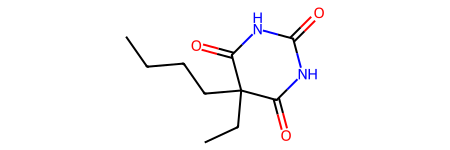

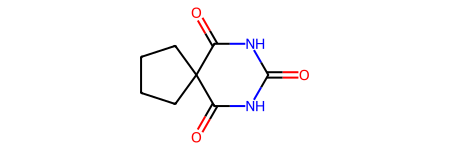

These molecules had a similarity of 0.9545454545454546


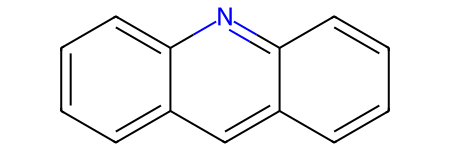

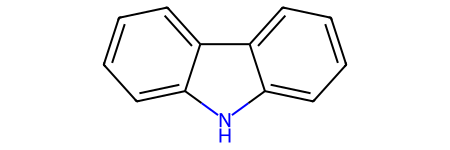

These molecules had a similarity of 0.976


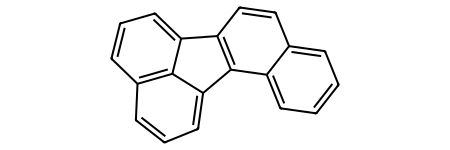

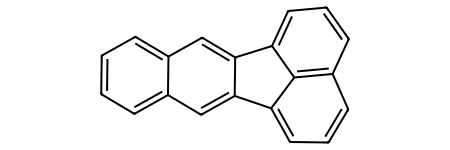

These molecules had a similarity of 0.973404255319149


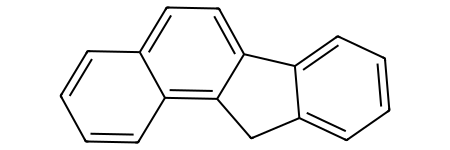

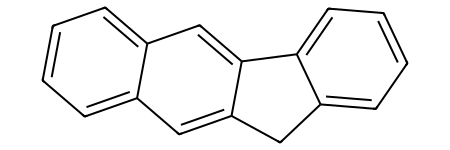

These molecules had a similarity of 0.972972972972973


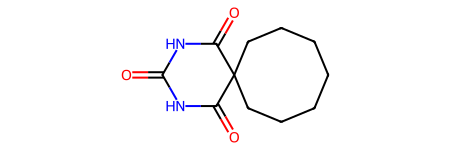

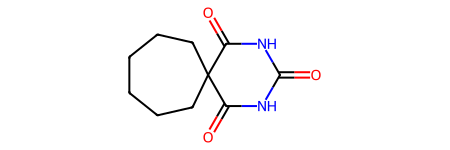

These molecules had a similarity of 0.9501779359430605


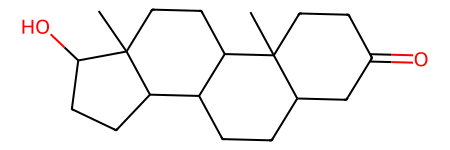

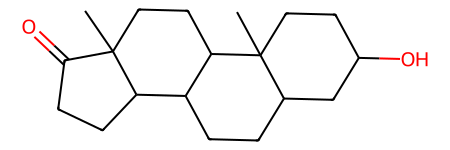

These molecules had a similarity of 0.9501779359430605


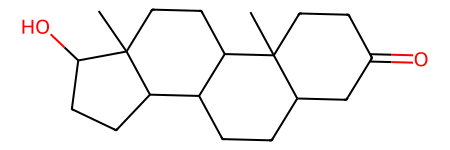

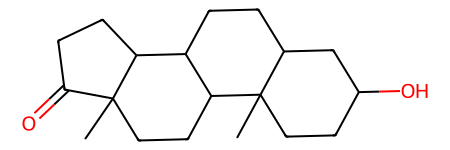

These molecules had a similarity of 0.9681274900398407


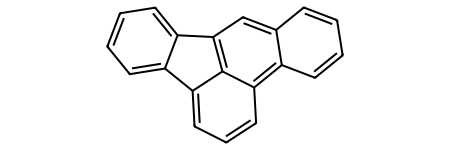

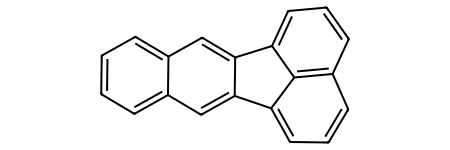

In [15]:
similarity_matrix = np.zeros((len(train_fps), len(test_fps)))
for i, fp1 in enumerate(train_fps):
    for j, fp2 in enumerate(test_fps):
        sim = DataStructs.TanimotoSimilarity(fp1, fp2)
        if sim > 0.95:
            print(f'These molecules had a similarity of {sim}')
            display(train_mols[i])
            display(test_mols[j])
        similarity_matrix[i, j] = sim

In [16]:
similarity_matrix.shape

(960, 112)

Now calculate the average similarity of a test molecule to the N nearest neighbors in the training set

In [17]:
num_NNs = 3
NN_mean_distances = []
for j in range(similarity_matrix.shape[1]):
    temp_sim_array = similarity_matrix[:, j]
    temp_NN_array = temp_sim_array[temp_sim_array.argsort()[-num_NNs:][::-1]]
    NN_mean_distances.append(np.mean(temp_NN_array))

In [18]:
NN_mean_distances = np.array(NN_mean_distances)
NN_mean_distances.shape

(112,)

In [19]:
uncertainties = 1 - NN_mean_distances
uncertainties

array([0.28137859, 0.30319737, 0.44607936, 0.36586483, 0.3083926 ,
       0.36419961, 0.40440477, 0.60624464, 0.47049289, 0.09102854,
       0.40771193, 0.64371616, 0.68329208, 0.24049968, 0.41246284,
       0.64449202, 0.6014082 , 0.66614249, 0.57475441, 0.53202667,
       0.19526939, 0.56119607, 0.57291902, 0.56713768, 0.48000642,
       0.5557842 , 0.53665059, 0.54213525, 0.55021769, 0.51953557,
       0.55307921, 0.55695174, 0.55247759, 0.57743077, 0.52061974,
       0.57550394, 0.57475891, 0.53495057, 0.54307392, 0.54252745,
       0.54879818, 0.51314501, 0.52842092, 0.06723556, 0.67426449,
       0.8452263 , 0.58275046, 0.14708995, 0.1422619 , 0.53854927,
       0.80897756, 0.45021419, 0.13364106, 0.52156863, 0.6448523 ,
       0.39133043, 0.71622079, 0.73036294, 0.1959707 , 0.26767677,
       0.28023599, 0.33720342, 0.32331759, 0.32331759, 0.53972156,
       0.14294068, 0.16468795, 0.58906347, 0.09457851, 0.17328918,
       0.51740594, 0.12483953, 0.21707954, 0.35255878, 0.51135

# Do these uncertainties (dissimilarities) correlate with larger prediction errors?

In [20]:
# first look at the overall model performance
calc_regression_metrics(y_test, y_pred)

(0.6513385508500582,
 0.8506767340474962,
 0.8554545997606923,
 SignificanceResult(statistic=0.7551907291163688, pvalue=3.98943313558296e-32),
 SignificanceResult(statistic=0.9101707149355281, pvalue=6.565853485504151e-44))

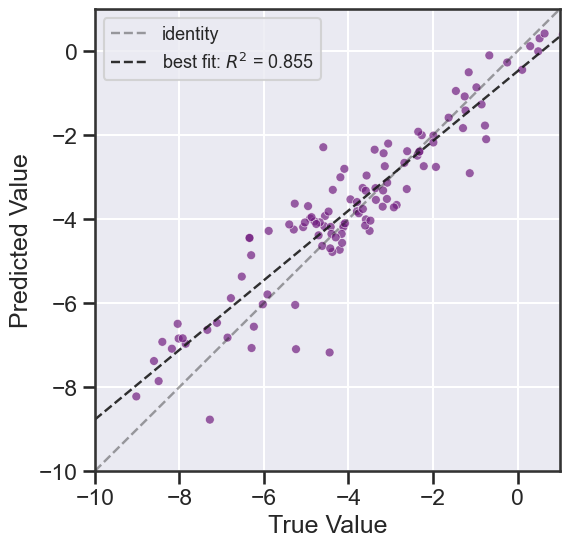

In [21]:
fig, ax = draw_parity_plot(y_test, y_pred)

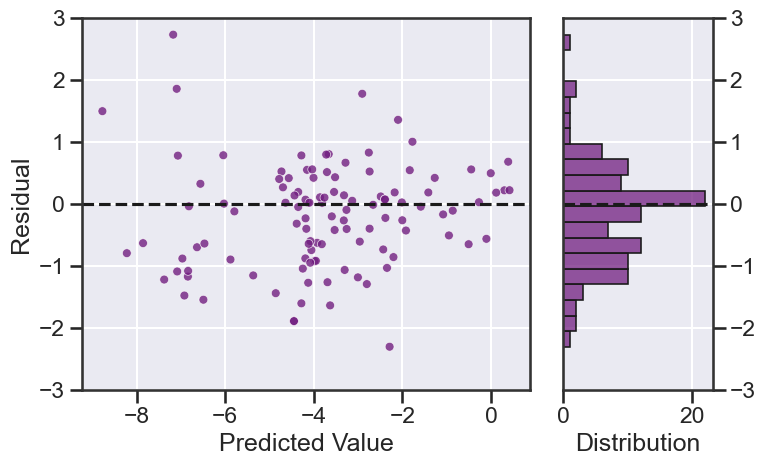

In [22]:
fig, ax = plot_residuals(y_test, y_pred)

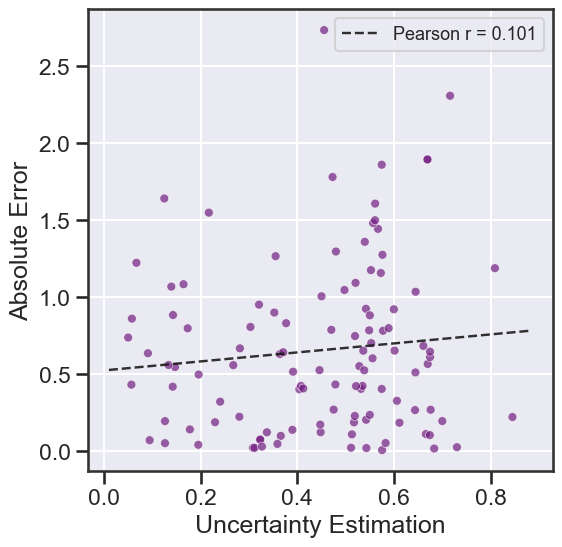

In [23]:
abs_error = abs(y_test - y_pred)
fig, ax = plot_abs_err_vs_uncertainties(uncertainties, abs_error)